In [1]:
# import packages for visualization
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from map_plan import *

import copy

In [2]:
sample_map = create_sample_map()
true_obstacle_map = sample_map[:,:,0]
goal_map = sample_map[:,:,1]
current_pos_map = sample_map[:,:,2]

In [37]:
# start from the current position,
# make the observation of the map and update the obstacle map,
# perform a trajectory optimization,
# move to the second position in the trajectory,
# and repeat.

n_total_steps = 100
n_obstacle_steps = 20
n_trajectory_steps = 20
trajectory_length = 20

# maximum range of each transition
max_length = 3

# initialize the obstacle map
obstacle_map = 0.01 * torch.randn_like(true_obstacle_map)
obstacle_map.requires_grad = True

# initialize the current position
current_position = get_hard_position(current_pos_map, argmax=True)

# initialize the goal position
goal_position = get_hard_position(goal_map, argmax=True)

# initialize the obstacle optimizer
obstacle_optimizer = optim.Adam([obstacle_map], lr=0.01)

# all positions
positions = [[current_position[0].item(), current_position[1].item()]]

# all distances
distances = []

trajectory = None

print(f'step {0}, position: {current_position}')

# iterate over the total number of steps
for i in range(n_total_steps):
    current_position = [current_position[0].item(), current_position[1].item()]

    # make noisy observation of the map
    noisy_view_bot = obstacle_view(true_obstacle_map, 
                                   get_soft_position(*current_position, beta=0.1), 
                                   noise=0.05)
    
    # update the estimated obstacle map
    loss = update_obstacle_map(obstacle_map,
                               get_soft_position(*current_position, beta=0.1), 
                               noisy_view_bot, 
                               optimizer=obstacle_optimizer,
                               n_steps=n_obstacle_steps)
    
    # perform a trajectory optimization
    if trajectory is not None:
        new_trajectory = trajectory.clone().detach()
        new_trajectory[:-1] = trajectory[1:]
        new_trajectory[-1] = trajectory[-2]
        new_trajectory = new_trajectory + 0.01 * torch.randn_like(trajectory)
        trajectory = new_trajectory.clone().detach()

    trajectory = optimize_trajectory(torch.sigmoid(obstacle_map.clone().detach()), 
                                     goal_map,
                                     get_soft_position(*current_position, beta=0.1), 
                                     trajectory_length=trajectory_length, 
                                     num_iterations=n_trajectory_steps,
                                     initial_trajectory=trajectory)

    # move to the first position in the trajectory that differs from the current position
    new_position = None
    for j in range(trajectory_length):
        if torch.norm(torch.round(trajectory[j]) - 
                      torch.round(torch.tensor(current_position)).float()) > 0.:
            new_position = trajectory[j]
            break
    if new_position is None:
        print('No new position found')
        break
    
    # move to the new position
    delta_position = (torch.round(new_position).detach() - 
                      torch.round(torch.tensor(current_position)))

    # cap the delta
    delta_position = torch.clamp(delta_position, -max_length, max_length)

    # update the current position
    current_position = move_position(*current_position, *delta_position.long(), true_obstacle_map)

    # store the current position
    positions.append([current_position[0].item(), current_position[1].item()])

    # distance to the goal from current_position
    distance = torch.norm(torch.tensor(current_position).float() - 
                          torch.tensor(goal_position).float()).item()

    # store the distance
    distances.append(distance)

    if i % 10 == 0:
        print(f'step {i+1}, position: {current_position}, distance to the goal: {distance}')

    if distance <= 2.:
        print('Goal reached!')
        break

step 0, position: (tensor(0), tensor(0))
step 1, position: (tensor(0), tensor(0)), distance to the goal: 21.470911026000977
step 11, position: (tensor(4), tensor(2)), distance to the goal: 17.0
step 21, position: (tensor(9), tensor(12)), distance to the goal: 10.198039054870605
Goal reached!


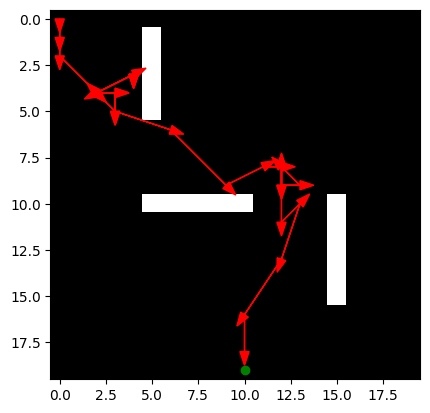

In [38]:
# visualize the trajectory over the true obstacle and goal position.
plt.imshow(true_obstacle_map, cmap='gray')
plt.scatter(*(goal_position[::-1]), c='g')
# plot the positions in positions and connect them with arrows
for i in range(len(positions) - 1):
    plt.arrow(positions[i][1], positions[i][0], 
              *(np.array(positions[i+1])[::-1] - np.array(positions[i])[::-1]), 
              head_width=0.5, color='r')
plt.show()

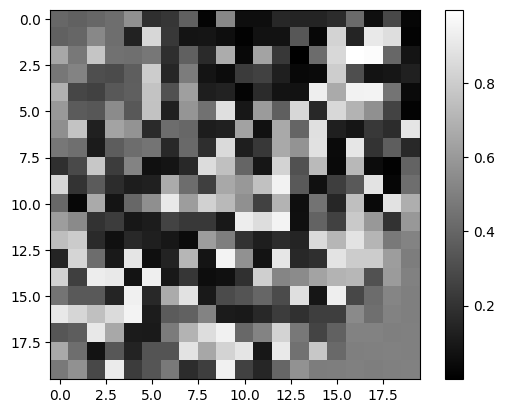

In [36]:
# visualize the estimated obstacle map
plt.imshow(torch.sigmoid(obstacle_map.detach()).numpy(), cmap='gray')
plt.colorbar()
plt.show()

In [77]:
new_position

(tensor(2), tensor(1))

In [78]:
current_position

[0, 0]